# Practical 2: Generative and Discriminative Models

In this practical, we'll compare:
- Naive Bayes Classifier (NBC)
- Logistic Regression Classifier (LR)

In [42]:
import numpy as np
import math, random
import sklearn
from scipy.stats import norm as gaussian
from matplotlib import pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

## Naive Bayes Classifier

For real-value inputs, we use univariant Gaussian to model $p(x_i | y=c)=\mathcal N(\mu_{ic}, \sigma^2_{ic})$.
It's known that the MLE for this model is exactly the empirical mean and varince, i.e.:
$$
\mu_{ic} = \text{Mean}(x_i^{(j)}), \forall y^{(j)} = c\\
\sigma^2_{ic} = \text{Variance}(x_i^{(j)}), \forall y^{(j)} = c
$$

For binary features, $p(x_i=1 | y=c)=\theta_{ic}, p(x_i=0 | y=c)=1-\theta_{ic} \Leftrightarrow p(x_i | y=c) = \theta_{ic}^{x_i}(1-\theta_{ic})^{1-x_i}$, where:
$$
\theta_{ic} = \cfrac{N_{x_i=1,y=c}}{N_{y=c}}
$$

And modelling $p(y=c)$ is similar:
$$
\pi_c = \cfrac{N_{y=c}}{N}
$$

During prediction, NBC predicts by $\hat y = \argmax_{y\in\mathcal C} p(\mathbf x, y=c | \mathbf\mu_{\cdot c},\mathbf{\sigma_{\cdot c}}^2)$, where:
$$
p(\mathbf x, y=c | \mathbf\mu,\mathbf{\sigma}^2) = \pi_c\cdot\prod_{j=1}^D p(x_{j} | \mu_{jc},\sigma_{jc}^2)
$$

And logarithmically:
$$

\log p(\mathbf x, y=c | \mathbf\mu,\mathbf{\sigma}^2) = \log\pi_c + \sum_{j} \log p(x_{j} | y = c)\\
=\log\pi_c - \sum_{j, x_{j}\text{ is real}} \log \sqrt{2\pi}\sigma_{jc} - \sum_{j, x_{j}\text{ is real}} \cfrac{(x_j-\mu_{jc})^2}{2\sigma_{jc}^2} + \sum_{j, x_{j}\text{ is binary}}({x_j}\log\theta_{ic} + (1-x_j)\log(1-\theta_{ic}))
$$


In [87]:
class NBC:
    def __init__(self, feature_types=None, num_classes=None):
        self.real_idx = []
        self.binary_idx = []
        for i, t in enumerate(feature_types):
            assert t == 'r' or t == 'b', "Feature type must be either 'r' for real, or 'b' for binary!"
            if t == 'b': #raise NotImplementedError("Binary features are not supported yet! (don't feel like to implement it actually)")
                self.binary_idx.append(i)
            else:
                self.real_idx.append(i)
        assert num_classes > 1, "Number of classes should be at least 2!"
        self.feature_types = feature_types
        self.num_classes = num_classes

        # Model of p(y = c)
        self.pis = np.ndarray(self.num_classes, np.float) # \pi_c; shape of (num_classes)
        
        # Model of p(x_i | y = c)
        self.mus = np.ndarray((self.num_classes, len(feature_types)), np.float) # Gaussian means; shape of (num_classes, num_dimensions)
        self.sigma2s = np.ndarray((self.num_classes, len(feature_types)), np.float) # Gaussian variance; shape of (num_classes, num_dimensions)
        self.thetas = np.ndarray((self.num_classes, len(feature_types)), np.float) # Bernolli; shape of (num_classes, num_dimensions)
    
    def gaussian_p_x_given_y(self, x, y): # Gaussian
        return gaussian.pdf(x, loc=self.mus[y], scale=self.sigma2s[y])
    
    def fit(self, X, y):
        assert len(X.shape) == 2

        for c in range(self.num_classes):
            # Estimate p(y = c)
            self.pis[c] = y[y == c].shape[0] / y.shape[0]

            # Estimate p(x | y = c)
            X_c = X[y == c]
            ## Real entries
            self.mus[c, self.real_idx] = X_c[:, self.real_idx].mean(axis=0)
            self.sigma2s[c, self.real_idx] = np.maximum(X_c[:, self.real_idx].var(axis=0), 1e-6)
            ## Binary entries
            self.thetas[c, self.binary_idx] = (np.sum(np.equal(X_c[:, self.binary_idx], 1.0), axis=0) + 1) / (X_c.shape[0] + 2)
    
    def predict(self, X):
        logits = None # eventually be of shape (num_classes, num_inputs)
        inits = np.log(self.pis) - np.sum(np.log(np.sqrt(np.pi) * np.sqrt(self.sigma2s[:, self.real_idx])), axis=1)
        # print(inits.shape)
        for c in range(self.num_classes):
            term = inits[c]
            if len(self.real_idx) > 0: term -= np.sum((X - self.mus[c, self.real_idx]) ** 2 / (2 * self.sigma2s[c, self.real_idx]), axis=1) # real entries
            if len(self.binary_idx) > 0: term += np.sum(X * np.log(self.thetas[c, self.binary_idx]) + (1 - X) * np.log(1 - self.thetas[c, self.binary_idx]), axis=1) # binary entries
            term = np.expand_dims(term, axis=1)
            if logits is None:
                logits = term
                # print(logits.shape)
            else: logits = np.concatenate((logits, term), axis=1)
        # print(logits.shape)
        pred = np.argmax(logits, axis=1)
        return pred

### Iris

In [114]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris['data'], iris['target']

num_inputs = X.shape[0]
train_num = int(num_inputs * 2 / 3)
test_num = num_inputs - train_num

y_train = y_test = []
while(len(set(y_train)) < len(set(y)) or len(set(y_test)) < len(set(y))):
    train_idx = random.sample(range(num_inputs), k=train_num)
    test_idx = list(set(range(num_inputs)) - set(train_idx))

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

print("Train set:", X_train.shape[0])
print("Test set:", X_test.shape[0])

nbc = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc.fit(X_train, y_train)

pred = nbc.predict(X_test)
print("Test Prec: {:.2f}".format(np.sum(pred == y_test) / y_test.shape[0]))

pred = nbc.predict(X_train)
print("Train Prec: {:.2f}".format(np.sum(pred == y_train) / y_train.shape[0]))

Train set: 100
Test set: 50
Test Prec: 0.96
Train Prec: 0.96


### Voting

In [115]:
import pickle as cp

X, y = cp.load(open('voting.pickle', 'rb'))

num_inputs = X.shape[0]
train_num = int(num_inputs * 2 / 3)
test_num = num_inputs - train_num

y_train = y_test = []
while(len(set(y_train)) < len(set(y)) or len(set(y_test)) < len(set(y))):
    train_idx = random.sample(range(num_inputs), k=train_num)
    test_idx = list(set(range(num_inputs)) - set(train_idx))

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

print("Train set:", X_train.shape[0])
print("Test set:", X_test.shape[0])

# nbc = NBC(feature_types=['r' for i in range(16)], num_classes=2) # Assuming features being real-value does better?
nbc = NBC(feature_types=['b' for i in range(16)], num_classes=2)
nbc.fit(X_train, y_train)

pred = nbc.predict(X_test)
print("Test Prec: {:.2f}".format(np.sum(pred == y_test) / y_test.shape[0]))

pred = nbc.predict(X_train)
print("Train Prec: {:.2f}".format(np.sum(pred == y_train) / y_train.shape[0]))

Train set: 154
Test set: 78
Test Prec: 0.94
Train Prec: 0.90


## Logistic Regression

**Handin1**: Set $C=5$ in $\min_{w, c} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1)$ would be equivalent to $\lambda = 0.1$ in the lectures' optimization form.

### Iris

In [116]:
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X, y = iris['data'], iris['target']

num_inputs = X.shape[0]
train_num = int(num_inputs * 2 / 3)
test_num = num_inputs - train_num

y_train = y_test = []
while(len(set(y_train)) < len(set(y)) or len(set(y_test)) < len(set(y))):
    train_idx = random.sample(range(num_inputs), k=train_num)
    test_idx = list(set(range(num_inputs)) - set(train_idx))

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

print("Train set:", X_train.shape[0])
print("Test set:", X_test.shape[0])

nbc = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc.fit(X_train, y_train)

pred = nbc.predict(X_test)
print("Test Prec: {:.2f}".format(np.sum(pred == y_test) / y_test.shape[0]))

pred = nbc.predict(X_train)
print("Train Prec: {:.2f}".format(np.sum(pred == y_train) / y_train.shape[0]))


Train set: 100
Test set: 50
Test Prec: 0.94
Train Prec: 0.97


### Voting

In [117]:
X, y = cp.load(open('voting.pickle', 'rb'))

num_inputs = X.shape[0]
train_num = int(num_inputs * 2 / 3)
test_num = num_inputs - train_num

y_train = y_test = []
while(len(set(y_train)) < len(set(y)) or len(set(y_test)) < len(set(y))):
    train_idx = random.sample(range(num_inputs), k=train_num)
    test_idx = list(set(range(num_inputs)) - set(train_idx))

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

print("Train set:", X_train.shape[0])
print("Test set:", X_test.shape[0])


lr = LogisticRegression(random_state=0, penalty='l2', solver='liblinear').fit(X_train, y_train)

pred = lr.predict(X_test)
print("Test Prec: {:.2f}".format(np.sum(pred == y_test) / y_test.shape[0]))

pred = lr.predict(X_train)
print("Train Prec: {:.2f}".format(np.sum(pred == y_train) / y_train.shape[0]))


Train set: 154
Test set: 78
Test Prec: 0.95
Train Prec: 0.97


## Comparison

### Iris

In [118]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
num_division = 10
num_iter = 1000
nbc_errors = []
lr_errors = []

N_train_ori = int(0.8 * N)
shuffler = np.random.permutation(N)
X_train_ori = X[shuffler[:N_train_ori]]
y_train_ori = y[shuffler[:N_train_ori]]
X_test = X[shuffler[N_train_ori:]]
y_test = y[shuffler[N_train_ori:]]

for k in tqdm(range(num_division)):
    nbc_error = lr_error = 0.0
    for it in range(num_iter):
        N_train = int(N_train_ori * (k + 1) * 0.1)
        y_train = []
        while len(set(y_train)) < len(set(y)): # in case there is a class where no sample is provided
            shuffler = np.random.permutation(N_train_ori)
            X_train = X_train_ori[shuffler[:N_train]]
            y_train = y_train_ori[shuffler[:N_train]]

        nbc = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
        nbc.fit(X_train, y_train)
        nbc_pred = nbc.predict(X_test)
        nbc_error += np.sum(nbc_pred == y_test) / y_test.shape[0]

        lr = LogisticRegression(random_state=0, penalty='l1', solver='liblinear').fit(X_train, y_train)
        lr_pred = lr.predict(X_test)
        lr_error += np.sum(lr_pred == y_test) / y_test.shape[0]
    nbc_error /= num_iter
    lr_error /= num_iter
    nbc_errors.append(1 - nbc_error)
    lr_errors.append(1 - lr_error)

100%|██████████| 10/10 [00:40<00:00,  4.07s/it]


NBC err: 0.0631333333333497
LR err: 0.0


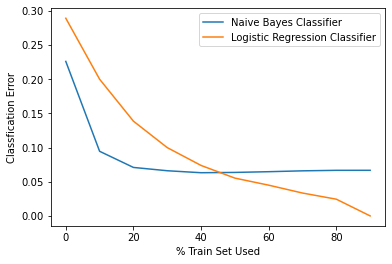

In [122]:
print("NBC err:", np.min(nbc_errors))
print("LR err:", np.min(lr_errors))
plt.plot(range(0, 10 * num_division, 10), nbc_errors, label='Naive Bayes Classifier')
plt.plot(range(0, 10 * num_division, 10), lr_errors, label='Logistic Regression Classifier')

plt.xlabel("% Train Set Used")
plt.ylabel("Classfication Error")

plt.legend()
plt.show()
# plt.savefig('iris_comparison_liblinear_l1.png')

### Voting

**It seems that assuming features being real-valued could produce better NBC classifiers?**

In [140]:
import pickle as cp
X, y = cp.load(open('voting.pickle', 'rb'))

N, D = X.shape
num_division = 10
num_iter = 1000
nbc_errors = []
lr_errors = []

N_train_ori = int(0.8 * N)
shuffler = np.random.permutation(N)
X_train_ori = X[shuffler[:N_train_ori]]
y_train_ori = y[shuffler[:N_train_ori]]
X_test = X[shuffler[N_train_ori:]]
y_test = y[shuffler[N_train_ori:]]

for k in tqdm(range(num_division)):
    nbc_error = lr_error = 0.0
    for it in range(num_iter):
        N_train = int(N_train_ori * (k + 1) * 0.1)
        y_train = []
        while len(set(y_train)) < len(set(y)): # in case there is a class where no sample is provided
            shuffler = np.random.permutation(N_train_ori)
            X_train = X_train_ori[shuffler[:N_train]]
            y_train = y_train_ori[shuffler[:N_train]]

        nbc = NBC(feature_types=['b' for i in range(16)], num_classes=2)
        nbc.fit(X_train, y_train)
        nbc_pred = nbc.predict(X_test)
        nbc_error += np.sum(nbc_pred == y_test) / y_test.shape[0]

        lr = LogisticRegression(random_state=0, penalty='l1', solver='liblinear').fit(X_train, y_train)
        lr_pred = lr.predict(X_test)
        lr_error += np.sum(lr_pred == y_test) / y_test.shape[0]
    nbc_error /= num_iter
    lr_error /= num_iter
    nbc_errors.append(1 - nbc_error)
    lr_errors.append(1 - lr_error)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


NBC err: 0.04248936170211681
LR err: 0.0


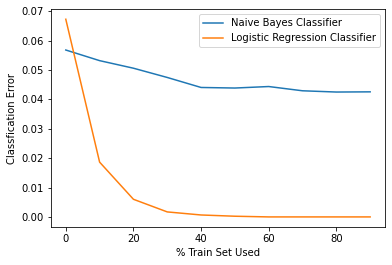

In [143]:
print("NBC err:", np.min(nbc_errors))
print("LR err:", np.min(lr_errors))
plt.plot(range(0, 10 * num_division, 10), nbc_errors, label='Naive Bayes Classifier')
plt.plot(range(0, 10 * num_division, 10), lr_errors, label='Logistic Regression Classifier')

plt.xlabel("% Train Set Used")
plt.ylabel("Classfication Error")

plt.legend()
plt.show()
# plt.savefig('voting_comparison_liblinear_l1.png')